In [3]:
import pandas_datareader.data as web
df = web.DataReader('USDCAD=X', 'yahoo', start='2007-07-22', end='2012-03-28')

<AxesSubplot:xlabel='Date'>

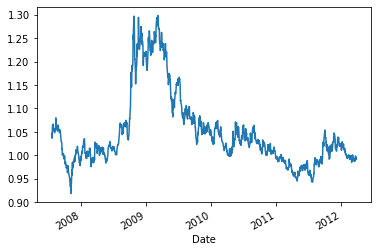

In [4]:
data = df['Adj Close']
data.plot()

In [22]:
#### 귀무가설 기각할 수 없음 - Stationary하다
from statsmodels.tsa.stattools import adfuller
adfuller(data, maxlag=1, regression='c')


(-1.814955679296744,
 0.37306229931987056,
 0,
 1215,
 {'1%': -3.435743555099632,
  '5%': -2.8639217381867486,
  '10%': -2.568038075665972},
 -8111.811359194424)

In [18]:
import numpy as np
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.tsatools import lagmat, add_trend
from statsmodels.tsa.adfvalues import mackinnonp

def adf(ts):
    ts = np.asarray(ts)
    
    nobs = ts.shape[0]
    maxlag = 1
    tsdiff = np.diff(ts)
    
    tsdall = lagmat(tsdiff[:, None], maxlag, trim = 'both', original = 'in')
    nobs = tsdall.shape[0]
    tsdall[:, 0] = ts[-nobs - 1:-1]
    tsdshort = tsdiff[-nobs:]
    
    results = OLS(tsdshort, add_trend(tsdall[:, :maxlag + 1], 'c')).fit()
    adfstat = results.tvalues[0]
    
    pvalue = mackinnonp(adfstat, 'c', N=1)
    return (adfstat, pvalue)

In [19]:
adf(data)

(-1.8319637867741008, 0.3647119589771163)

In [63]:
def get_hurst_exponent(ts, max_lag = 20):
    
    lags = range(2, max_lag)
    tau = []
    for lag in lags:
        diff = np.subtract(np.array(ts[lag:]), np.array(ts[:-lag]))
        tau.append(np.std(diff))
        
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    
    return reg[0]

In [64]:
get_hurst_exponent(data)

0.4665241917919693

In [65]:
def hurst(ts):
    """
    Returns the Hurst Exponent of the time series vector ts
    """
    # make sure we are working with an array, convert if necessary
    ts = np.asarray(ts)

    # Helper variables used during calculations
    lagvec = []
    tau = []
    # Create the range of lag values
    lags = range(2, 100)

    #  Step through the different lags
    for lag in lags:
        #  produce value difference with lag
        pdiff = np.subtract(ts[lag:],ts[:-lag])
        #  Write the different lags into a vector
        lagvec.append(lag)
        #  Calculate the variance of the difference vector
        tau.append(np.std(pdiff))

    #  linear fit to double-log graph
    m = np.polyfit(np.log10(np.asarray(lagvec)),
                   np.log10(np.asarray(tau).clip(min=0.0000000001)),
                   1)
    # return the calculated hurst exponent
    return m[0]

In [ ]:
def variance_ratio_test(ts, lag = 2):
    ts = np.asarray(ts)
    diff1 = np.substract(ts[1:], ts[:-1])
    difftau = 

In [67]:
#### ??? 왜 이렇게 되는거지???
def variance_ratio(ts, lag = 2):
    """
    Returns the variance ratio test result
    """
    # make sure we are working with an array, convert if necessary
    ts = np.asarray(ts)
    
    # Apply the formula to calculate the test
    n = len(ts)
    mu  = sum(ts[1:n]-ts[:n-1])/n;
    m=(n-lag+1)*(1-lag/n);
    b=sum(np.square(ts[1:n]-ts[:n-1]-mu))/(n-1)
    t=sum(np.square(ts[lag:n]-ts[:n-lag]-lag*mu))/m
    return t/(lag*b);

In [68]:
variance_ratio(data)

1.0078634031661593

In [97]:
#### example 2.4 설명대로 수행(regression 활용)
def half_life(ts):
    ts = np.asarray(ts)
    delta_ts = np.diff(ts)
    lag_ts = np.vstack([ts[1:], np.ones(len(ts[1:]))]).T
    lamda_sol = np.linalg.lstsq(lag_ts, delta_ts)
    print('lamda:', lamda_sol[0][0])
    return (np.log(2) / lamda_sol[0])[0]   #### (-) 붙여야되는거 아닌가?

### lamda가 양수이므로 price series is not at all mean reverting(??)

In [98]:
half_life(data)

lamda: 0.005971846408856899


/Users/qook/Coding/Finance_ML/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


116.06915736009762

In [144]:
def lag_fun(ts, lag_num):
    return np.hstack([np.zeros(lag_num), np.asarray(data)[:-lag_num]]).T

In [145]:
def backtest_linear_mean_reverting(ts):
    lookback = round(half_life(ts))
    mktVal = -(ts - ts.rolling(lookback).mean()) / (ts.rolling(lookback).std())
    lag_mktVal = pd.Series(lag_fun(mktVal, 1))
    lag_ts = pd.Series(lag_fun(ts, 1))
    pnl = lag_mktVal * (ts.reset_index()['Adj Close'] - lag_ts) / lag_ts
    return pnl

In [146]:
backtest_linear_mean_reverting(data)

lamda: 0.005971846408856899


/Users/qook/Coding/Finance_ML/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


0           NaN
1      -0.01016
2       0.00520
3       0.01180
4       0.01030
         ...   
1211    0.00090
1212    0.00680
1213   -0.00230
1214   -0.00510
1215    0.00420
Length: 1216, dtype: float64

lamda: 0.005971846408856899


/Users/qook/Coding/Finance_ML/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


<AxesSubplot:>

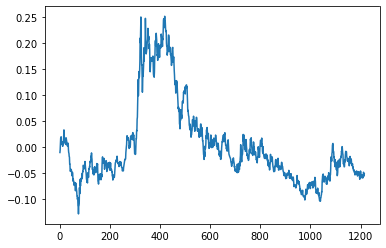

In [147]:
backtest_linear_mean_reverting(data).cumsum().plot()

In [67]:
df_ewa = web.DataReader('EWA', 'yahoo', start='2006-04-21', end='2012-04-09')
df_ewc = web.DataReader('EWC', 'yahoo', start='2006-04-21', end='2012-04-09')

In [6]:
import pandas as pd
df_ewa_data = df_ewa['Adj Close']
df_ewc_data = df_ewc['Adj Close']
df_ewa_ewc = pd.concat([df_ewa_data, df_ewc_data], axis = 1)
df_ewa_ewc.columns = ['ewa', 'ewc']

In [7]:
df_ewa_ewc

,ewa,ewc
Date,,
2006-04-20,10.209894,17.952795
2006-04-21,10.349230,18.179020
2006-04-24,10.330010,18.069557
2006-04-25,10.334815,18.098751
2006-04-26,10.541413,18.149839
...,...,...
2012-04-02,14.910575,23.201002
2012-04-03,14.677101,22.854605
2012-04-04,14.500421,22.451807


<AxesSubplot:xlabel='Date'>

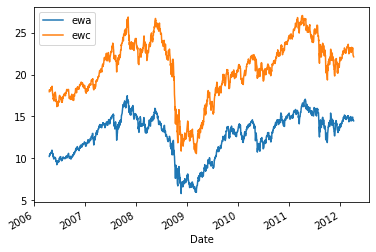

In [8]:
df_ewa_ewc.plot()

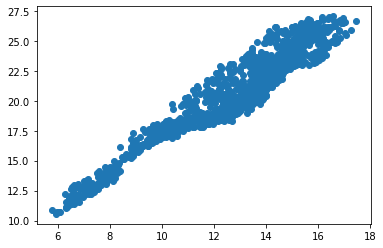

In [9]:
import matplotlib.pyplot as plt
plt.scatter(df_ewa_ewc['ewa'], df_ewa_ewc['ewc'])

In [46]:
import numpy as np
from sklearn.linear_model import LinearRegression

x = pd.concat([pd.DataFrame(np.ones(len(df_ewc_data))), df_ewc_data.reset_index()['Adj Close']], axis = 1)

lr = LinearRegression()

lr_fit = lr.fit(x, df_ewa_data.reset_index()['Adj Close'])

In [47]:
lr_fit.coef_

array([0.       , 0.6775692])

In [52]:
import numpy as np
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.tsatools import lagmat, add_trend
from statsmodels.tsa.adfvalues import mackinnonp

def adf(ts, maxlag = 1):
    ts = np.asarray(ts)
    nobs = ts.shape[0]
    
    tsdiff = np.diff(ts)
    tsdall = lagmat(tsdiff[:, None], maxlag, trim='both', original='in')
    nobs = tsdall.shape[0]
    
    tsdall[:, 0] = ts[-nobs -1 : -1]
    tsdshort = tsdiff[-nobs:]
    
    results = OLS(tsdshort, add_trend(tsdall[:, :maxlag + 1], 'c')).fit()
    adfstat = results.tvalues[0]
    
    pvalue = mackinnonp(adfstat, 'c', N= 1)
    return pvalue
   

In [53]:
def cadf(x, y):
    ols_result = OLS(x, y).fit()
    
    return adf(ols_result.resid)

In [54]:
cadf(df_ewc_data.reset_index()['Adj Close'], df_ewa_data.reset_index()['Adj Close'])

0.008842161749869822

In [83]:
from statsmodels.tsa.stattools import adfuller

In [84]:
def cadf2(x, y):
    ols_result = OLS(x, y).fit()
    
    return adfuller(ols_result.resid)

In [85]:
cadf2(df_ewc_data.reset_index()['Adj Close'], df_ewa_data.reset_index()['Adj Close'])

(-2.879947192503294,
 0.04773005247953831,
 10,
 1493,
 {'1%': -3.4347375276423335,
  '5%': -2.8634778123668374,
  '10%': -2.5678016687520104},
 133.1371916621829)

In [55]:

import numpy as np
from statsmodels.tsa.tsatools import lagmat
 
 
def johansen(ts, lags):
    """
    Calculate the Johansen Test for the given time series
    """
    # Make sure we are working with arrays, convert if necessary
    ts = np.asarray(ts)
 
    # nobs is the number of observations
    # m is the number of series
    nobs, m = ts.shape
 
    # Obtain the cointegrating vectors and corresponding eigenvalues
    eigenvectors, eigenvalues = maximum_likelihood_estimation(ts, lags)
 
    # Build table of critical values for the hypothesis test
    critical_values_string = """2.71   3.84    6.63
             13.43   15.50   19.94
             27.07   29.80   35.46
             44.49   47.86   54.68
             65.82   69.82   77.82
             91.11   95.75   104.96
             120.37  125.61  135.97
             153.63  159.53  171.09
             190.88  197.37  210.06
             232.11  239.25  253.24
             277.38  285.14  300.29
             326.53  334.98  351.25"""
    select_critical_values = np.array(
            critical_values_string.split(),
            float).reshape(-1, 3)
    critical_values = select_critical_values[:, 1]
 
    # Calculate numbers of cointegrating relations for which
    # the null hypothesis is rejected
    rejected_r_values = []
    for r in range(m):
        if h_test(eigenvalues, r, nobs, lags, critical_values):
            rejected_r_values.append(r)
 
    return eigenvectors, rejected_r_values

 
def h_test(eigenvalues, r, nobs, lags, critical_values):
    """
    Helper to execute the hypothesis test
    """
    # Calculate statistic
    t = nobs - lags - 1
    m = len(eigenvalues)
    statistic = -t * np.sum(np.log(np.ones(m) - eigenvalues)[r:])
 
    # Get the critical value
    critical_value = critical_values[m - r - 1]
 
    # Finally, check the hypothesis
    if statistic > critical_value:
        return True
    else:
        return False
 
 
def maximum_likelihood_estimation(ts, lags):
    """
    Obtain the cointegrating vectors and corresponding eigenvalues
    """
    # Make sure we are working with array, convert if necessary
    ts = np.asarray(ts)
 
    # Calculate the differences of ts
    ts_diff = np.diff(ts, axis=0)
 
    # Calculate lags of ts_diff.
    ts_diff_lags = lagmat(ts_diff, lags, trim='both')
 
    # First lag of ts
    ts_lag = lagmat(ts, 1, trim='both')
 
    # Trim ts_diff and ts_lag
    ts_diff = ts_diff[lags:]
    ts_lag = ts_lag[lags:]
 
    # Include intercept in the regressions
    ones = np.ones((ts_diff_lags.shape[0], 1))
    ts_diff_lags = np.append(ts_diff_lags, ones, axis=1)
 
    # Calculate the residuals of the regressions of diffs and lags
    # into ts_diff_lags
    inverse = np.linalg.pinv(ts_diff_lags)
    u = ts_diff - np.dot(ts_diff_lags, np.dot(inverse, ts_diff))
    v = ts_lag - np.dot(ts_diff_lags, np.dot(inverse, ts_lag))
 
    # Covariance matrices of the calculated residuals
    t = ts_diff_lags.shape[0]
    Svv = np.dot(v.T, v) / t
    Suu = np.dot(u.T, u) / t
    Suv = np.dot(u.T, v) / t
    Svu = Suv.T
 
    # ToDo: check for singular matrices and exit
    Svv_inv = np.linalg.inv(Svv)
    Suu_inv = np.linalg.inv(Suu)
 
    # Calculate eigenvalues and eigenvectors of the product of covariances
    cov_prod = np.dot(Svv_inv, np.dot(Svu, np.dot(Suu_inv, Suv)))
    eigenvalues, eigenvectors = np.linalg.eig(cov_prod)
 
    # Use Cholesky decomposition on eigenvectors
    evec_Svv_evec = np.dot(eigenvectors.T, np.dot(Svv, eigenvectors))
    cholesky_factor = np.linalg.cholesky(evec_Svv_evec)
    eigenvectors = np.dot(eigenvectors, np.linalg.inv(cholesky_factor.T))
 
    # Order the eigenvalues and eigenvectors
    indices_ordered = np.argsort(eigenvalues)
    indices_ordered = np.flipud(indices_ordered)
 
    # Return the calculated values
    return eigenvalues[indices_ordered], eigenvectors[:, indices_ordered]

In [56]:
data = pd.concat([df_ewc_data.reset_index()['Adj Close'], df_ewa_data.reset_index()['Adj Close']], axis = 1)

In [57]:
data

,Adj Close,Adj Close
0,17.952795,10.209894
1,18.179020,10.349230
2,18.069557,10.330010
3,18.098751,10.334815
4,18.149839,10.541413
...,...,...
1499,23.201002,14.910575
1500,22.854605,14.677101
1501,22.451807,14.500421
1502,22.322914,14.588765


In [58]:
johansen(data, 1)

(array([0.0108875 , 0.00265691]), [0])

In [60]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

j = coint_johansen(data, det_order=0, k_ar_diff=1)

In [63]:
#### joahnsen test trace statistic
j.trace_stat

array([20.43868734,  3.99599546])

In [77]:
#### joahnsen test trace statistic critical value(90%, 95%, 99%)
j.trace_stat_crit_vals

array([[13.4294, 15.4943, 19.9349],
       [ 2.7055,  3.8415,  6.6349]])

In [65]:
#### joahnsen test eigen statistic
j.max_eig_stat

array([16.44269188,  3.99599546])

In [78]:
#### joahnse test eigen statistic critical value(90%, 95%, 99%)
j.max_eig_stat_crit_vals

array([[12.2971, 14.2639, 18.52  ],
       [ 2.7055,  3.8415,  6.6349]])

In [68]:
df_ige = web.DataReader('IGE', 'yahoo', start='2006-04-21', end='2012-04-09')

In [69]:
df_ige_data = df_ige['Adj Close']

In [70]:
data2 = pd.concat([data, df_ige_data.reset_index()['Adj Close']], axis = 1)

In [72]:
jj = coint_johansen(data2, det_order=0, k_ar_diff=1)

In [73]:
jj.trace_stat

array([35.5188876 , 17.59813944,  4.6976483 ])

In [79]:
jj.trace_stat_crit_vals

array([[27.0669, 29.7961, 35.4628],
       [13.4294, 15.4943, 19.9349],
       [ 2.7055,  3.8415,  6.6349]])

In [74]:
jj.max_eig_stat

array([17.92074816, 12.90049115,  4.6976483 ])

In [76]:
jj.max_eig_stat_crit_vals

array([[18.8928, 21.1314, 25.865 ],
       [12.2971, 14.2639, 18.52  ],
       [ 2.7055,  3.8415,  6.6349]])

In [80]:
jj.eig

array([0.01186036, 0.0085521 , 0.00312271])

In [82]:
jj.evec

array([[ 1.38175512,  0.74304843, -0.38239317],
       [-1.45068783,  0.17810397, -0.07834962],
       [-0.29609892, -0.69420754,  0.12288914]])